In [2]:
pip install selenium webdriver-manager


Note: you may need to restart the kernel to use updated packages.


## Getting longitude and latitude of 20 Indian cities using Geocode maps API

In [3]:
import requests
import pandas as pd
import time 
API_KEY = "67c490b3a3c78893272577xmvd2c31f"

def get_lat_lon(city, country="India"):
    """
    Fetches latitude and longitude for a given city using Geocode Maps.co API.

    Parameters:
    - city (str): Name of the city
    - country (str, optional): Country name (default: India)

    Returns:
    - tuple: (latitude, longitude) or (None, None) if not found
    """
    url = f"https://geocode.maps.co/search?q={city},{country}&format=json&api_key={API_KEY}"
    
    try:
        response = requests.get(url)
        response.raise_for_status()  
        data = response.json()

        if data:
            lat = float(data[0]["lat"])
            lon = float(data[0]["lon"])
            return lat, lon
        else:
            return None, None

    except requests.exceptions.RequestException as e:
        print(f"⚠ Error fetching data for {city}: {e}")
        return None, None

indian_cities = [
    "Mumbai", "Delhi", "Bengaluru", "Hyderabad", "Ahmedabad", 
    "Chennai", "Kolkata", "Surat", "Pune", "Jaipur", 
    "Lucknow", "Kanpur", "Nagpur", "Indore", "Thane", 
    "Bhopal", "Visakhapatnam", "Patna", "Vadodara", "Ghaziabad"
]

city_data = []
for city in indian_cities:
    lat, lon = get_lat_lon(city)
    city_data.append({"City": city, "Latitude": lat, "Longitude": lon})
    time.sleep(1)

df_cities = pd.DataFrame(city_data)



In [4]:
df_cities

,City,Latitude,Longitude
0,Mumbai,19.081577,72.886628
1,Delhi,28.627393,77.171695
2,Bengaluru,12.976794,77.590082
3,Hyderabad,17.360589,78.474061
4,Ahmedabad,23.021624,72.579707
5,Chennai,13.083694,80.270186
6,Kolkata,22.572646,88.363895
7,Surat,21.209489,72.831706
8,Pune,18.521428,73.854454
9,Jaipur,26.915458,75.818982


## Getting current weather of the 20 cities using open-meteo.com

In [5]:
def get_current_weather(latitude, longitude):
    url = f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current_weather=true"
    response = requests.get(url)
    data = response.json()
    return data


In [6]:
current_data = {}
for i in range(df_cities.shape[0]):  
    city = df_cities.iloc[i, 0] 
    latitude = df_cities.iloc[i, 1]  
    longitude = df_cities.iloc[i, 2]  
    data = get_current_weather(latitude, longitude)
    current_data_list = []
    current_data_list.append({
        "Latitude": latitude,
        "Longitude": longitude,
        "Timestamp": data["current_weather"]["time"],
        "Temperature(degrees Celsius)": data["current_weather"]["temperature"],
        "Wind direction(degrees)": data["current_weather"]["winddirection"],
        "Wind Speed (m/s)": data["current_weather"]["windspeed"]
    })
    current_data[city] = pd.DataFrame(current_data_list)


In [7]:
current_data

{'Mumbai':     Latitude  Longitude         Timestamp  Temperature(degrees Celsius)  \
 0  19.081577  72.886628  2025-03-08T11:45                          30.5   
 
    Wind direction(degrees)  Wind Speed (m/s)  
 0                      298              10.6  ,
 'Delhi':     Latitude  Longitude         Timestamp  Temperature(degrees Celsius)  \
 0  28.627393  77.171695  2025-03-08T11:45                          27.9   
 
    Wind direction(degrees)  Wind Speed (m/s)  
 0                      294               7.9  ,
 'Bengaluru':     Latitude  Longitude         Timestamp  Temperature(degrees Celsius)  \
 0  12.976794  77.590082  2025-03-08T11:45                          31.9   
 
    Wind direction(degrees)  Wind Speed (m/s)  
 0                       48               8.7  ,
 'Hyderabad':     Latitude  Longitude         Timestamp  Temperature(degrees Celsius)  \
 0  17.360589  78.474061  2025-03-08T11:45                          35.3   
 
    Wind direction(degrees)  Wind Speed (m/s)  


In [8]:
current_data["Mumbai"]

,Latitude,Longitude,Timestamp,Temperature(degrees Celsius),Wind direction(degrees),Wind Speed (m/s)
0,19.081577,72.886628,2025-03-08T11:45,30.5,298,10.6


```python
import requests
import pandas as pd
import schedule
import time
from datetime import datetime

def collect_weather_data():
    """
    Collects current weather data for predefined cities and saves it to a CSV file.
    
    The function:
    - Fetches latitude and longitude for each city.
    - Retrieves the current weather data.
    - Stores the data in a Pandas DataFrame.
    - Appends the collected data to a CSV file for trend analysis.

    Runs daily at 12:00 PM IST.
    """
    current_data = {}
    current_data_list = []
    
    for city in indian_cities:
        latitude, longitude = get_lat_lon(city)
        if latitude and longitude:
            data = get_current_weather(latitude, longitude)
            
        current_data_list.append({
            "Latitude": latitude,
            "Longitude": longitude,
            "Timestamp": data["current_weather"]["time"],
            "Temperature(degrees Celsius)": data["current_weather"]["temperature"],
            "Wind direction(degrees)": data["current_weather"]["winddirection"],
            "Wind Speed (m/s)": data["current_weather"]["windspeed"]
        })
    current_data[city] = pd.DataFrame(current_data_list)
    
    print(f"Weather data collected & saved for {datetime.now().strftime('%Y-%m-%d')} at 12:00 IST")

# Schedule the function to run daily at 12:00 PM IST
schedule.every().day.at("06:30").do(collect_weather_data)  # 06:30 UTC = 12:00 IST

# Run the scheduler in a loop
while True:
    schedule.run_pending()
    time.sleep(60)  # Check every minute


## Getting historical weather of the 20 cities using open-meteo.com

In [9]:
def get_historical_weather(latitude, longitude, start_date, end_date):
    """
    Fetches historical weather data for a given location and date range.

    Parameters:
    - latitude (float): Latitude of the location.
    - longitude (float): Longitude of the location.
    - start_date (str): Start date in 'YYYY-MM-DD' format.
    - end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    - pd.DataFrame: Weather data as a Pandas DataFrame.
    """
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    params = {
        "latitude": latitude,
        "longitude": longitude,
        "start_date": start_date,
        "end_date": end_date,
        "hourly": "temperature_2m,relative_humidity_2m,wind_speed_10m"
    }
    
    response = requests.get(base_url, params=params)
    response.raise_for_status()  
    
    data = response.json()
    
    timestamps = data["hourly"]["time"]
    temperature = data["hourly"]["temperature_2m"]
    humidity = data["hourly"]["relative_humidity_2m"]
    wind_speed = data["hourly"]["wind_speed_10m"]
    
    df = pd.DataFrame({
        "Timestamp": timestamps,
        "Temperature (°C)": temperature,
        "Humidity (%)": humidity,
        "Wind Speed (m/s)": wind_speed
    })
    
    df["Timestamp"] = pd.to_datetime(df["Timestamp"])
    
    return df


In [10]:
start_date = "2025-01-30"
end_date = "2025-02-28"
weather_data = {}
for i in range(df_cities.shape[0]):  
    city = df_cities.iloc[i, 0] 
    latitude = df_cities.iloc[i, 1]  
    longitude = df_cities.iloc[i, 2]  

    weather_df = get_historical_weather(latitude, longitude, start_date, end_date)

    weather_data[city] = weather_df


In [11]:
weather_data

{'Mumbai':               Timestamp  Temperature (°C)  Humidity (%)  Wind Speed (m/s)
 0   2025-01-30 00:00:00              21.1            65               6.5
 1   2025-01-30 01:00:00              20.4            72               6.5
 2   2025-01-30 02:00:00              20.3            71               6.7
 3   2025-01-30 03:00:00              21.9            64               6.6
 4   2025-01-30 04:00:00              24.8            53               4.0
 ..                  ...               ...           ...               ...
 715 2025-02-28 19:00:00              27.2            41               9.0
 716 2025-02-28 20:00:00              26.5            44               8.2
 717 2025-02-28 21:00:00              26.2            45              10.9
 718 2025-02-28 22:00:00              26.1            45              12.1
 719 2025-02-28 23:00:00              25.9            47              11.6
 
 [720 rows x 4 columns],
 'Delhi':               Timestamp  Temperature (°C)  Humidity (

In [12]:
for city, df in weather_data.items():
    print(f"City: {city}, weather_data : {df.head()}")

City: Mumbai, weather_data :             Timestamp  Temperature (°C)  Humidity (%)  Wind Speed (m/s)
0 2025-01-30 00:00:00              21.1            65               6.5
1 2025-01-30 01:00:00              20.4            72               6.5
2 2025-01-30 02:00:00              20.3            71               6.7
3 2025-01-30 03:00:00              21.9            64               6.6
4 2025-01-30 04:00:00              24.8            53               4.0
City: Delhi, weather_data :             Timestamp  Temperature (°C)  Humidity (%)  Wind Speed (m/s)
0 2025-01-30 00:00:00              11.3            90               5.1
1 2025-01-30 01:00:00              11.1            91               5.2
2 2025-01-30 02:00:00              11.0            92               4.9
3 2025-01-30 03:00:00              12.9            83               6.9
4 2025-01-30 04:00:00              15.7            70               4.6
City: Bengaluru, weather_data :             Timestamp  Temperature (°C)  Humidi

In [13]:
weather_data['Kolkata']

,Timestamp,Temperature (°C),Humidity (%),Wind Speed (m/s)
0,2025-01-30 00:00:00,19.8,94,7.7
1,2025-01-30 01:00:00,20.2,94,8.1
2,2025-01-30 02:00:00,21.8,89,11.4
3,2025-01-30 03:00:00,23.5,83,15.8
4,2025-01-30 04:00:00,25.5,71,15.7
...,...,...,...,...
715,2025-02-28 19:00:00,22.7,92,5.8
716,2025-02-28 20:00:00,22.4,94,7.0
717,2025-02-28 21:00:00,22.3,95,6.1
718,2025-02-28 22:00:00,22.1,95,6.0


In [15]:
import os
output_folder = "/Users/user/Downloads/weather_data_last_30_days"
os.makedirs(output_folder, exist_ok=True)

In [16]:
for city, df in weather_data.items():
    city_clean = city.replace(" ", "_")
    
    filename = f"{city_clean}_{start_date}_to_{end_date}.csv"
    filepath = os.path.join(output_folder, filename)
    
    df.to_csv(filepath, index=False)

    print(f"Saved {city} weather data to {filepath}")


Saved Mumbai weather data to /Users/user/Downloads/weather_data_last_30_days/Mumbai_2025-01-30_to_2025-02-28.csv
Saved Delhi weather data to /Users/user/Downloads/weather_data_last_30_days/Delhi_2025-01-30_to_2025-02-28.csv
Saved Bengaluru weather data to /Users/user/Downloads/weather_data_last_30_days/Bengaluru_2025-01-30_to_2025-02-28.csv
Saved Hyderabad weather data to /Users/user/Downloads/weather_data_last_30_days/Hyderabad_2025-01-30_to_2025-02-28.csv
Saved Ahmedabad weather data to /Users/user/Downloads/weather_data_last_30_days/Ahmedabad_2025-01-30_to_2025-02-28.csv
Saved Chennai weather data to /Users/user/Downloads/weather_data_last_30_days/Chennai_2025-01-30_to_2025-02-28.csv
Saved Kolkata weather data to /Users/user/Downloads/weather_data_last_30_days/Kolkata_2025-01-30_to_2025-02-28.csv
Saved Surat weather data to /Users/user/Downloads/weather_data_last_30_days/Surat_2025-01-30_to_2025-02-28.csv
Saved Pune weather data to /Users/user/Downloads/weather_data_last_30_days/Pun

### Loading in the files from disk, to observe trends 

In [17]:
import os


In [18]:
input_folder = "/Users/user/Downloads/weather_data_last_30_days"

In [19]:
weather_files = [f for f in os.listdir(input_folder) if f.endswith(".csv")]

print(f"Found {len(weather_files)} weather files!")

Found 20 weather files!


In [20]:
weather_files

['Delhi_2025-01-30_to_2025-02-28.csv',
 'Ghaziabad_2025-01-30_to_2025-02-28.csv',
 'Patna_2025-01-30_to_2025-02-28.csv',
 'Surat_2025-01-30_to_2025-02-28.csv',
 'Vadodara_2025-01-30_to_2025-02-28.csv',
 'Mumbai_2025-01-30_to_2025-02-28.csv',
 'Lucknow_2025-01-30_to_2025-02-28.csv',
 'Jaipur_2025-01-30_to_2025-02-28.csv',
 'Hyderabad_2025-01-30_to_2025-02-28.csv',
 'Kanpur_2025-01-30_to_2025-02-28.csv',
 'Pune_2025-01-30_to_2025-02-28.csv',
 'Bengaluru_2025-01-30_to_2025-02-28.csv',
 'Chennai_2025-01-30_to_2025-02-28.csv',
 'Kolkata_2025-01-30_to_2025-02-28.csv',
 'Thane_2025-01-30_to_2025-02-28.csv',
 'Visakhapatnam_2025-01-30_to_2025-02-28.csv',
 'Indore_2025-01-30_to_2025-02-28.csv',
 'Bhopal_2025-01-30_to_2025-02-28.csv',
 'Ahmedabad_2025-01-30_to_2025-02-28.csv',
 'Nagpur_2025-01-30_to_2025-02-28.csv']

In [21]:
dfs = {}
for file in weather_files:
    city = file.split('_')[0]
    dfs[city] = pd.read_csv(f"/Users/user/Downloads/weather_data_last_30_days/{file}")

In [22]:
dfs['Kolkata']

,Timestamp,Temperature (°C),Humidity (%),Wind Speed (m/s)
0,2025-01-30 00:00:00,19.8,94,7.7
1,2025-01-30 01:00:00,20.2,94,8.1
2,2025-01-30 02:00:00,21.8,89,11.4
3,2025-01-30 03:00:00,23.5,83,15.8
4,2025-01-30 04:00:00,25.5,71,15.7
...,...,...,...,...
715,2025-02-28 19:00:00,22.7,92,5.8
716,2025-02-28 20:00:00,22.4,94,7.0
717,2025-02-28 21:00:00,22.3,95,6.1
718,2025-02-28 22:00:00,22.1,95,6.0


In [23]:
for city, df in dfs.items():
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['date'] = df['Timestamp'].dt.date

In [24]:
df

,Timestamp,Temperature (°C),Humidity (%),Wind Speed (m/s),date
0,2025-01-30 00:00:00,21.4,69,4.7,2025-01-30
1,2025-01-30 01:00:00,21.1,71,4.1,2025-01-30
2,2025-01-30 02:00:00,21.3,70,4.2,2025-01-30
3,2025-01-30 03:00:00,23.2,62,2.4,2025-01-30
4,2025-01-30 04:00:00,25.9,53,4.1,2025-01-30
...,...,...,...,...,...
715,2025-02-28 19:00:00,27.1,28,8.6,2025-02-28
716,2025-02-28 20:00:00,25.4,31,2.5,2025-02-28
717,2025-02-28 21:00:00,24.9,32,9.3,2025-02-28
718,2025-02-28 22:00:00,23.8,35,4.1,2025-02-28


In [25]:
avg_temp_dfs = {}
for city, df in dfs.items():
    avg_temp_df = df.groupby('date').agg({'Temperature (°C)' : 'mean'})
    avg_temp_dfs[city] = avg_temp_df

In [26]:
avg_temp_dfs['Delhi']

,Temperature (°C)
date,
2025-01-30,18.125000
2025-01-31,18.741667
2025-02-01,18.800000
2025-02-02,16.933333
2025-02-03,16.262500
2025-02-04,17.275000
2025-02-05,15.433333
2025-02-06,15.154167
2025-02-07,15.004167


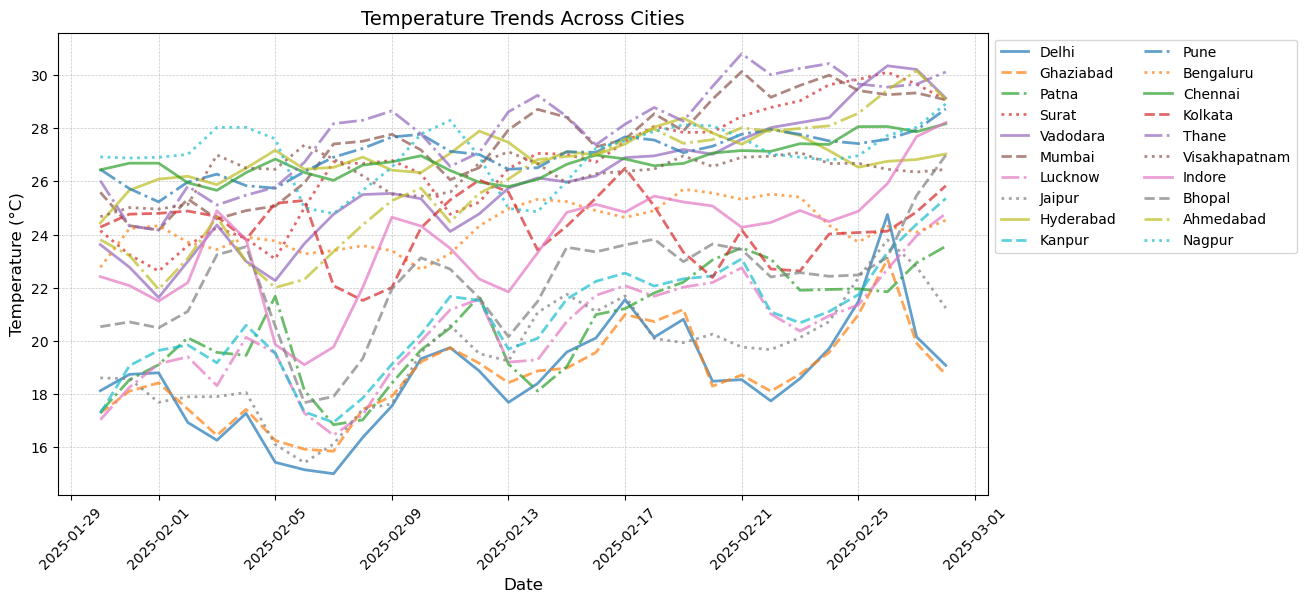

In [27]:

import itertools

plt.figure(figsize=(12, 6))

line_styles = itertools.cycle(["-", "--", "-.", ":"])  # Alternate line styles

for city, df in avg_temp_dfs.items():
    plt.plot(df.index, df["Temperature (°C)"], linestyle=next(line_styles), alpha=0.7, linewidth=2, label=city)

# Formatting
plt.title("Temperature Trends Across Cities", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)

# Improved legend placement
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=10, ncol=2)

plt.show()


### Now creating sequential data(previous 48 hours of data for each hour)

In [28]:
import numpy as np
def create_tuples(dfs, SEQ_LENGTH):
    X, Y = [], []
    for city, df in dfs.items():
        for i in range(len(df) - SEQ_LENGTH):
            X.append(df.iloc[i:i+SEQ_LENGTH]["Temperature (°C)"].values)  
            Y.append(df.iloc[i+SEQ_LENGTH]["Temperature (°C)"])           
    return X, Y


In [29]:
SEQ_LENGTH = 48
X, Y = create_tuples(dfs, SEQ_LENGTH)
X = np.array(X)
Y = np.array(Y)

In [30]:
X.shape

(13440, 48)

In [31]:
Y.shape

(13440,)

## Training an LSTM to predict temperature of the next one hour based on the last 48 hours

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Add extra dimension for LSTM
Y_tensor = torch.tensor(Y, dtype=torch.float32)

In [33]:
class TemperatureDataset(Dataset):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

# Split into train and test
train_size = int(0.8 * len(X))
train_X, test_X = X_tensor[:train_size], X_tensor[train_size:]
train_Y, test_Y = Y_tensor[:train_size], Y_tensor[train_size:]

train_dataset = TemperatureDataset(train_X, train_Y)
test_dataset = TemperatureDataset(test_X, test_Y)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [44]:
import torch.nn as nn

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=64, num_layers=2):
        super(LSTMPredictor, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)  

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  
        output = self.fc(lstm_out[:, -1, :])  
        return output

model = LSTMPredictor()


In [45]:
import torch.optim as optim
from tqdm import tqdm

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 40
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# List to store losses
loss_history = []

In [46]:


# Training loop with tqdm
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", leave=False)
    
    for X_batch, Y_batch in progress_bar:
        X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
        
        optimizer.zero_grad()
        Y_pred = model(X_batch).squeeze()
        loss = criterion(Y_pred, Y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())  # Update tqdm bar with current loss
    
    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)  # Store loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/40, Loss: 190.0695


Epoch 2/40, Loss: 34.7758


Epoch 3/40, Loss: 31.5747


Epoch 4/40, Loss: 13.6422


Epoch 5/40, Loss: 2.3526


Epoch 6/40, Loss: 1.0614


Epoch 7/40, Loss: 0.6482


Epoch 8/40, Loss: 0.4587


Epoch 9/40, Loss: 0.3589


Epoch 10/40, Loss: 0.3021


Epoch 11/40, Loss: 0.2790


Epoch 12/40, Loss: 0.2428


Epoch 13/40, Loss: 0.2307


Epoch 14/40, Loss: 0.2075


Epoch 15/40, Loss: 0.1979


Epoch 16/40, Loss: 0.1997


Epoch 17/40, Loss: 0.1926


Epoch 18/40, Loss: 0.1889


Epoch 19/40, Loss: 0.1803


Epoch 20/40, Loss: 0.1802


Epoch 21/40, Loss: 0.1706


Epoch 22/40, Loss: 0.1781


Epoch 23/40, Loss: 0.1724


Epoch 24/40, Loss: 0.1698


Epoch 25/40, Loss: 0.1810


Epoch 26/40, Loss: 0.1650


Epoch 27/40, Loss: 0.1653


Epoch 28/40, Loss: 0.1718


Epoch 29/40, Loss: 0.1667


Epoch 30/40, Loss: 0.1608


Epoch 31/40, Loss: 0.1687


Epoch 32/40, Loss: 0.1585


Epoch 33/40, Loss: 0.1574


Epoch 34/40, Loss: 0.1603


Epoch 35/40, Loss: 0.1664


Epoch 36/40, Loss: 0.1653


Epoch 37/40, Loss: 0.1609


Epoch 38/40, Loss: 0.1599


Epoch 39/40, Loss: 0.1588


Epoch 40/40, Loss: 0.1640


### Printing training loss

Loss history: [190.06954932780494, 34.77581416709082, 31.57465670222328, 13.642239186912775, 2.352552640207467, 1.0614302117998402, 0.6481572327957976, 0.4586815025568718, 0.3589137041542147, 0.3020732054220779, 0.2789702190174943, 0.24276542483962008, 0.2307236391518797, 0.20749707434636852, 0.1978835943931093, 0.19970551066632783, 0.19257013892222727, 0.1889123841122325, 0.18025985914504244, 0.1801648671583583, 0.1706462004111104, 0.17814368137069755, 0.17242292144025365, 0.16982474765695987, 0.1810137847150188, 0.16497559426352382, 0.1652772853350533, 0.17184824487637906, 0.16672056557477585, 0.1607622425958869, 0.16870129660570196, 0.15846210217014664, 0.1573522746385563, 0.16033945453264528, 0.16642756009518744, 0.1652531268163806, 0.16089327216503166, 0.15994220128327252, 0.15876381440709034, 0.16401946617822563]


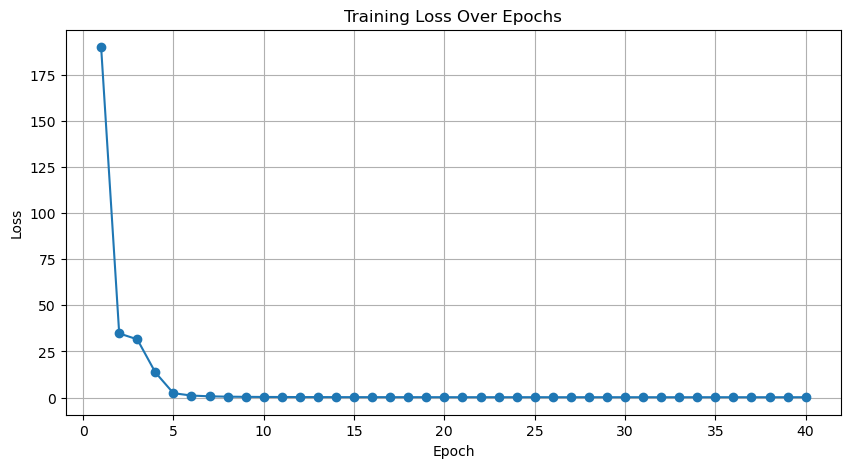

In [47]:
print("Loss history:", loss_history)

# Plot loss curve
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), loss_history, marker='o', linestyle='-')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.grid()
plt.show()


## Evaluating the trained model


Root Mean Squared Error in Temperature Prediction: 0.4183 °C

Actual vs. Predicted Temperatures:
Actual: 16.30 °C  |  Predicted: 16.20 °C
Actual: 15.70 °C  |  Predicted: 16.14 °C
Actual: 15.50 °C  |  Predicted: 15.93 °C
Actual: 17.30 °C  |  Predicted: 17.51 °C
Actual: 20.50 °C  |  Predicted: 20.12 °C
Actual: 23.20 °C  |  Predicted: 23.38 °C
Actual: 25.10 °C  |  Predicted: 25.25 °C
Actual: 26.60 °C  |  Predicted: 26.38 °C
Actual: 27.60 °C  |  Predicted: 27.62 °C
Actual: 28.00 °C  |  Predicted: 28.09 °C


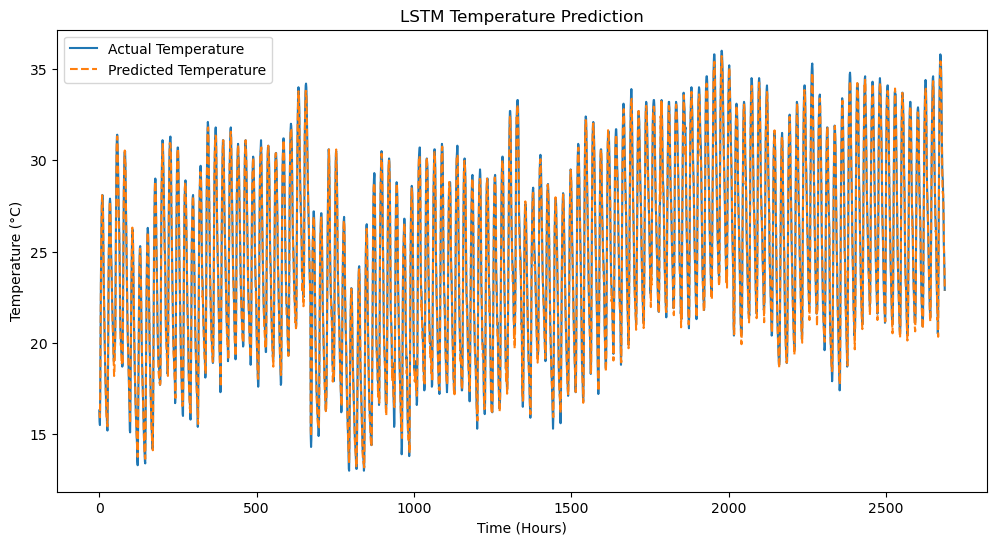

In [48]:
from sklearn.metrics import mean_squared_error
import torch
import numpy as np
import matplotlib.pyplot as plt

# Set model to evaluation mode
model.eval()
preds, actuals = [], []

# Disable gradient calculation
with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_pred = model(X_batch).squeeze().cpu().numpy()
        
        preds.extend(Y_pred)
        actuals.extend(Y_batch.cpu().numpy())

# Convert to numpy arrays
preds = np.array(preds)
actuals = np.array(actuals)

# Compute Mean Squared Error
mse = mean_squared_error(actuals, preds)
print(f"\nRoot Mean Squared Error in Temperature Prediction: {np.sqrt(mse):.4f} °C")

# Print some sample predictions
num_samples_to_print = 10  # Adjust as needed
print("\nActual vs. Predicted Temperatures:")
for i in range(min(num_samples_to_print, len(actuals))):
    print(f"Actual: {actuals[i]:.2f} °C  |  Predicted: {preds[i]:.2f} °C")

# Plot the results
plt.figure(figsize=(12,6))
plt.plot(actuals, label="Actual Temperature")
plt.plot(preds, label="Predicted Temperature", linestyle="--")
plt.xlabel("Time (Hours)")
plt.ylabel("Temperature (°C)")
plt.title("LSTM Temperature Prediction")
plt.legend()
plt.show()
